✅ Summary saved to: ../zymobiomics_folder/results/runs/runs_summary.csv


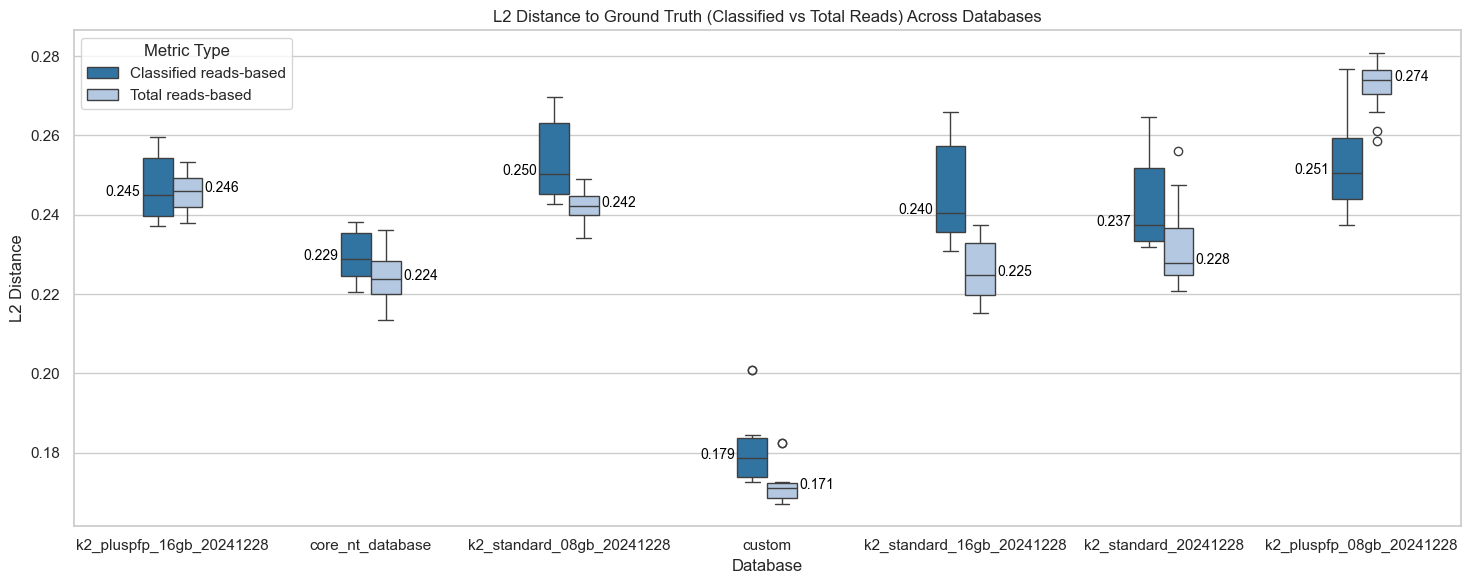

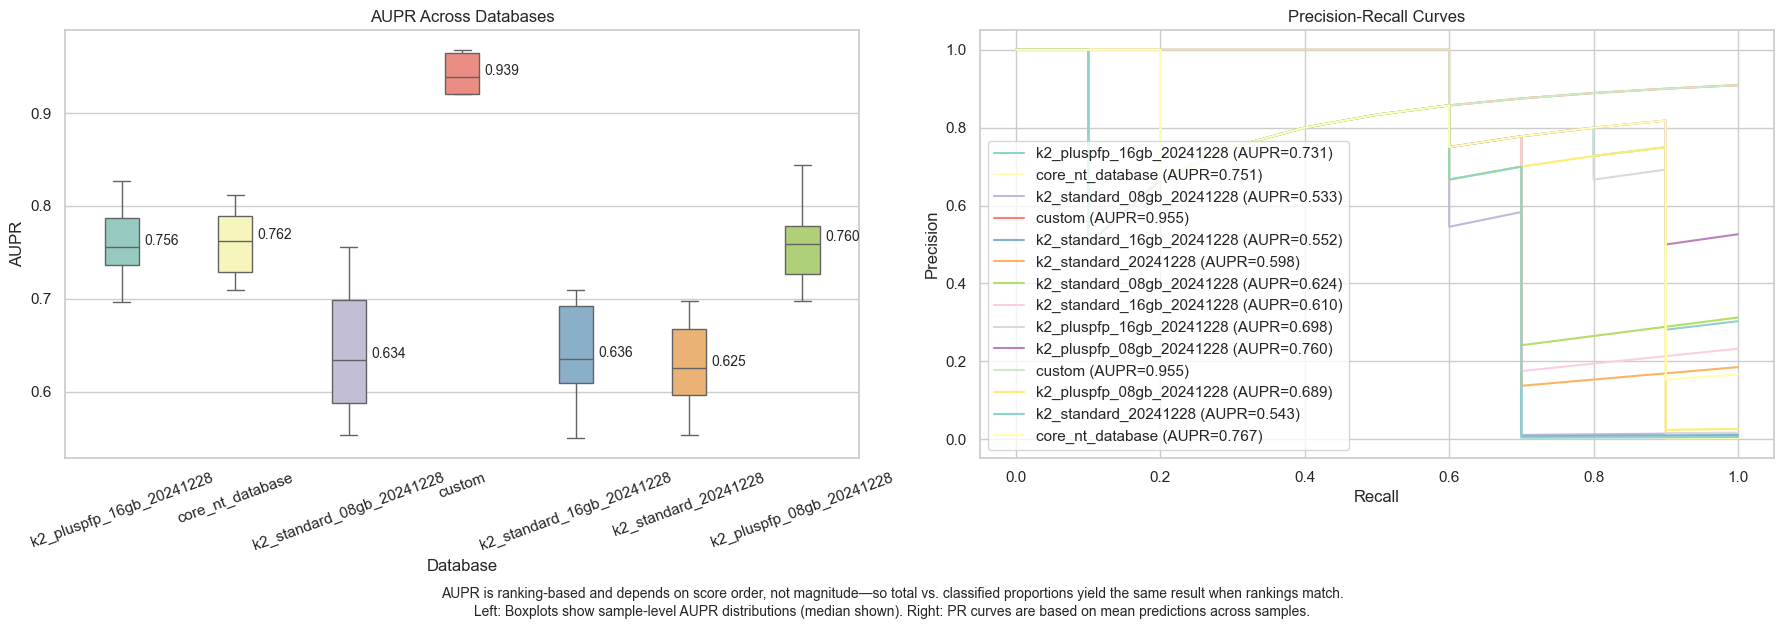

In [563]:
# Import  necessary libraries 
import pandas as pd  # Data handling
import re  # Regex for text cleaning
from html import unescape  # Decode HTML entities
import seaborn as sns  # Visualization
import matplotlib.pyplot as plt  # Plotting
import numpy as np  # Numerical operations
from sklearn.metrics import precision_recall_curve, auc  # PR curve and AUC
import os  # File operations
import math  # Math utilities
import subprocess

# Update the summary to reflect the current directory state
subprocess.run(["bash", "runs_summary.sh"])

# Load run metadata
metadata = pd.read_csv(
    "/Users/aliciahobdell/Desktop/forensic_bioinformatics_project/metagenome_analysis/zymobiomics_folder/results/runs/runs_summary.csv",
    index_col=False
)
runs = metadata[metadata["Database"] != "k2_eupathdb48_20230407"]["Run"].unique() # Exclude k2_eupathdb48_20230407 database from plots
samples = metadata["Sample"].unique()

# Load and normalize ground truth data
ground_truth = pd.read_csv(
    "/Users/aliciahobdell/Desktop/forensic_bioinformatics_project/metagenome_analysis/zymobiomics_folder/raw_data/ground_truth.csv"
)
ground_truth["abundance"] /= ground_truth["abundance"].sum()
ground_truth = ground_truth[ground_truth["abundance"] > 0]
gt_species_set = set(ground_truth["species"])

# Specify names for the columns of Bracken reports
headers = ['ReadFraction', 'TotalReads', 'KrakenReads', 'LevelID', 'TaxID', 'species']

# Initialize results list
results = []
all_pr_curves = []
    
# Iterate through each run and sample
for run_idx, run in enumerate(runs):
    
    # Get the database associated with the current run from the metadata
    db = metadata.loc[metadata['Run'] == run, 'Database'].values[0]

    # Store vectors  
    merged_tables = []
    
    # Initialize run-level data storage
    for sample_idx, sample in enumerate(samples):
        
        # Load Bracken report for current sample
        breport = pd.read_csv(
            f'/Users/aliciahobdell/Desktop/forensic_bioinformatics_project/metagenome_analysis/zymobiomics_folder/results/runs/{run}/reports/{sample}.breport',
            names=headers,
            sep='\t'
        )

        # Extract and clean species-level read counts
        sample_reads = breport[breport['LevelID'] == 'S'][['species', 'TotalReads']].copy()
        sample_reads['species'] = sample_reads['species'].str.strip()
        sample_reads = sample_reads[sample_reads['TotalReads'] > 0]
        sample_species_set = set(sample_reads['species'])

        # Get sample-level metadata for current run
        sample_metadata = metadata[(metadata['Run'] == run) & (metadata['Sample'] == sample)]

        # Normalize by classified and total reads
        sample_reads['ClassifiedProp'] = sample_reads['TotalReads'] / sample_reads['TotalReads'].sum()
        sample_reads['OverallProp'] = sample_reads['TotalReads'] / sample_metadata['TotalReads'].values[0]

        # L2 Distance
        all_species = list(gt_species_set.union(sample_reads['species']))
        gt_vector = ground_truth.set_index('species').reindex(all_species, fill_value=0)['abundance']
        class_vector = sample_reads.set_index('species').reindex(all_species, fill_value=0)['ClassifiedProp']
        tot_vector = sample_reads.set_index('species').reindex(all_species, fill_value=0)['OverallProp']

        class_l2_distance = np.linalg.norm(gt_vector - class_vector)
        tot_l2_distance = np.linalg.norm(gt_vector - tot_vector)

        # Precision and Recall
        true_positives = len(sample_species_set & gt_species_set)
        false_positives = len(sample_species_set - gt_species_set)
        false_negatives = len(gt_species_set - sample_species_set)

        precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) else 0.0
        recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) else 0.0

        # AUPR (Area Under Precision-Recall Curve)
        # Merge predictions with ground truth
        merged = pd.merge(ground_truth, sample_reads, on='species', how='outer').fillna(0)
        merged_tables.append(merged[['species', 'abundance', 'ClassifiedProp', 'OverallProp']])
        y_true = (merged['abundance'] > 0).astype(int)
        
        # AUPR using total reads
        tot_y_scores = merged['OverallProp']
        tot_precision_curve, tot_recall_curve, _ = precision_recall_curve(y_true, tot_y_scores)
        tot_aupr = auc(tot_recall_curve, tot_precision_curve)

        # AUPR using classified reads only
        class_y_scores = merged['ClassifiedProp']
        class_precision_curve, class_recall_curve, _ = precision_recall_curve(y_true, class_y_scores)
        class_aupr = auc(class_recall_curve, class_precision_curve)
                        
        # Save results for both metrics
        results.append({
            'db': db, 'run': run, 'sample': sample,
            'precision': precision, 'recall': recall,
            'metric_type': 'classified',
            'l2_distance': class_l2_distance,
            'aupr': class_aupr
        })

        results.append({
            'db': db, 'run': run, 'sample': sample,
            'precision': precision, 'recall': recall,
            'metric_type': 'overall',
            'l2_distance': tot_l2_distance,
            'aupr': tot_aupr
        })
        
        all_species_set.update(sample_reads['species'])

    # Concatenate all sample-level merged tables for this run
    merged_all = pd.concat(merged_tables)
    
    # Average PR curve for the run
    avg = pd.concat(merged_tables).groupby('species', as_index=False).mean()
    avg['y_true'] = (avg['abundance'] > 0).astype(int)
    precision, recall, _ = precision_recall_curve(avg['y_true'], avg['ClassifiedProp'])
    all_pr_curves.append({'run': run, 'db': db, 'precision': precision, 'recall': recall, 'aupr': auc(recall, precision)})    
    
# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Define custom colors and legend labels
custom_palette = {"classified": "#1f77b4", "overall": "#aec7e8"}
legend_labels = {
    'classified': 'Classified reads-based',
    'overall': 'Total reads-based'
}

# L2 Distance Boxplot
plt.figure(figsize=(15, 6))
ax = sns.boxplot(
    x="db", y="l2_distance", hue="metric_type", data=results_df,
    width=0.3, palette=custom_palette, dodge=True
)

# Annotate median L2 distances
medians = results_df.groupby(["db", "metric_type"])["l2_distance"].median()
xticks = ax.get_xticks()
xticklabels = [tick.get_text() for tick in ax.get_xticklabels()]
for xtick, label in zip(xticks, xticklabels):
    for metric in ["classified", "overall"]:
        median_val = medians[label, metric]
        x_offset = -0.25 if metric == "classified" else +0.25
        ax.text(xtick + x_offset, median_val - 0.001, f"{median_val:.3f}",
                ha='center', va='bottom', fontsize=10, color='black')

# Customize legend
handles, labels = ax.get_legend_handles_labels()
new_labels = [legend_labels[label] for label in labels]
ax.legend(handles=handles, labels=new_labels, title="Metric Type", loc='upper left')

# Final formatting for L2 distance plot
plt.xlabel("Database")
plt.ylabel("L2 Distance")
plt.title("L2 Distance to Ground Truth (Classified vs Total Reads) Across Databases")
plt.tight_layout()
plt.savefig("/Users/aliciahobdell/Desktop/forensic_bioinformatics_project/metagenome_analysis/zymobiomics_folder/results/l2_boxplot.png", bbox_inches='tight')
plt.show()

# Combined side-by-side AUPR boxplot + PR curves
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

# AUPR Boxplot
classified_df = results_df[results_df['metric_type'] == 'classified']
sns.boxplot(
    x="db", y="aupr", data=classified_df,
    width=0.3, palette="Set3", hue="db", legend=False, ax=axs[0]
)
axs[0].tick_params(axis='x', rotation=20)
# Annotate medians
medians = classified_df.groupby("db")["aupr"].median()
for xtick, label in zip(axs[0].get_xticks(), axs[0].get_xticklabels()):
    val = medians[label.get_text()]
    axs[0].text(xtick + 0.35, val - 0.001, f"{val:.3f}", ha='center', va='bottom', fontsize=10)

axs[0].set_title("AUPR Across Databases")
axs[0].set_xlabel("Database")
axs[0].set_ylabel("AUPR")

# Precision-Recall Curves 
colors = sns.color_palette("Set3", len(all_pr_curves))
for pr, color in zip(all_pr_curves, colors):
    axs[1].plot(pr['recall'], pr['precision'], label=f"{pr['db']} (AUPR={pr['aupr']:.3f})", color=color)

axs[1].set_title("Precision-Recall Curves")
axs[1].set_xlabel("Recall")
axs[1].set_ylabel("Precision")
axs[1].legend()
axs[1].grid(True)

# Add shared note below both plots
fig.text(0.5, -0.01,
         "AUPR is ranking-based and depends on score order, not magnitude—so total vs. classified proportions yield the same result when rankings match.",
         ha='center', fontsize=10)
fig.text(0.5, -0.04,
         "Left: Boxplots show sample-level AUPR distributions (median shown). Right: PR curves are based on mean predictions across samples.",
         ha='center', fontsize=10)
plt.tight_layout()
plt.savefig("/Users/aliciahobdell/Desktop/forensic_bioinformatics_project/metagenome_analysis/zymobiomics_folder/results/AUPR_PR_curves.png", bbox_inches='tight')
plt.show()